In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

datasets = Planetoid(root='~/GCN-RL/data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f"Dataset: {datasets}:")
print('====================')
print(f'Number of graphs: {len(datasets)}')
print(f'Number of features: {datasets.num_features}')
print(f'Number of classes: {datasets.num_classes}')

data = datasets[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')




Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


c:\Users\28154\anaconda3\envs\AIDD\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
c:\Users\28154\anaconda3\envs\AIDD\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


val_mask和test_mask分别表示这个点需要用到那个数据集中

In [10]:
# 可视化
# !pip install networkx
# !pip install matplotlib

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap='Set2')
    plt.show()
    

传统神经网络

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(datasets.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, datasets.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
    
model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [21]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=5e4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f'Test Accuracy: {test():.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9605
Epoch: 003, Loss: 1.9593
Epoch: 004, Loss: 1.9585
Epoch: 005, Loss: 1.9569
Epoch: 006, Loss: 1.9560
Epoch: 007, Loss: 1.9547
Epoch: 008, Loss: 1.9537
Epoch: 009, Loss: 1.9530
Epoch: 010, Loss: 1.9521
Epoch: 011, Loss: 1.9514
Epoch: 012, Loss: 1.9506
Epoch: 013, Loss: 1.9499
Epoch: 014, Loss: 1.9494
Epoch: 015, Loss: 1.9488
Epoch: 016, Loss: 1.9484
Epoch: 017, Loss: 1.9480
Epoch: 018, Loss: 1.9476
Epoch: 019, Loss: 1.9473
Epoch: 020, Loss: 1.9470
Epoch: 021, Loss: 1.9468
Epoch: 022, Loss: 1.9466
Epoch: 023, Loss: 1.9464
Epoch: 024, Loss: 1.9463
Epoch: 025, Loss: 1.9462
Epoch: 026, Loss: 1.9461
Epoch: 027, Loss: 1.9460
Epoch: 028, Loss: 1.9460
Epoch: 029, Loss: 1.9460
Epoch: 030, Loss: 1.9459
Epoch: 031, Loss: 1.9459
Epoch: 032, Loss: 1.9459
Epoch: 033, Loss: 1.9459
Epoch: 034, Loss: 1.9460
Epoch: 035, Loss: 1.9460
Epoch: 036, Loss: 1.9460
Epoch: 037, Loss: 1.9460
Epoch: 038, Loss: 1.9460
Epoch: 039, Loss: 1.9460
Epoch: 040, Loss: 1.9461


GNN

In [13]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(datasets.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, datasets.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


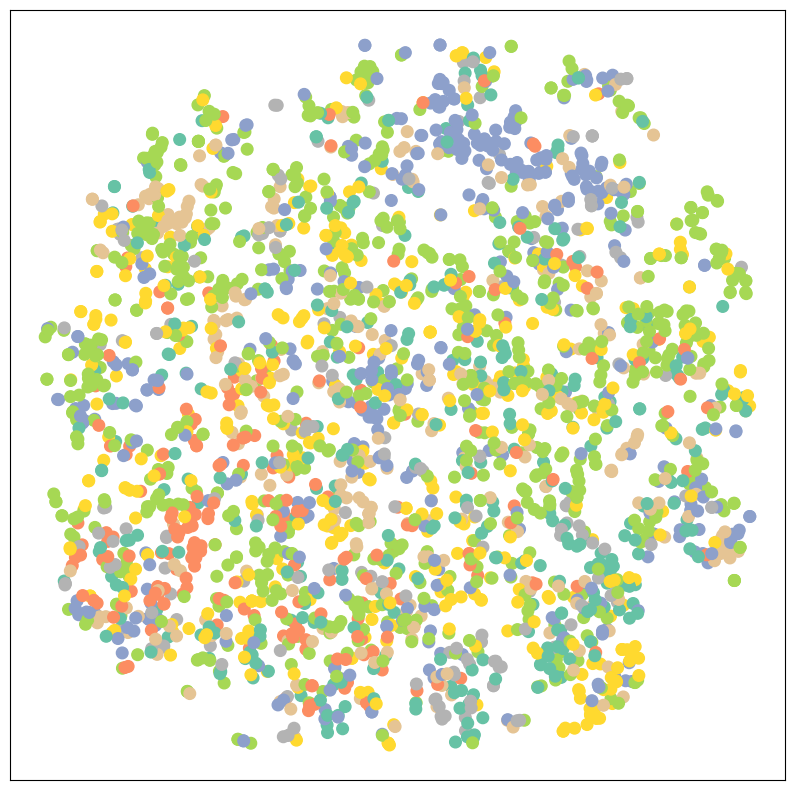

In [22]:
model = GCN(hidden_channels=16)
model.eval
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [29]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x,data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f'Test Accuracy: {test():.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9412
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9308
Epoch: 005, Loss: 1.9216
Epoch: 006, Loss: 1.9137
Epoch: 007, Loss: 1.9078
Epoch: 008, Loss: 1.8986
Epoch: 009, Loss: 1.8868
Epoch: 010, Loss: 1.8825
Epoch: 011, Loss: 1.8701
Epoch: 012, Loss: 1.8614
Epoch: 013, Loss: 1.8486
Epoch: 014, Loss: 1.8323
Epoch: 015, Loss: 1.8344
Epoch: 016, Loss: 1.8186
Epoch: 017, Loss: 1.8031
Epoch: 018, Loss: 1.7980
Epoch: 019, Loss: 1.7813
Epoch: 020, Loss: 1.7766
Epoch: 021, Loss: 1.7478
Epoch: 022, Loss: 1.7385
Epoch: 023, Loss: 1.7304
Epoch: 024, Loss: 1.7120
Epoch: 025, Loss: 1.7010
Epoch: 026, Loss: 1.6917
Epoch: 027, Loss: 1.6672
Epoch: 028, Loss: 1.6382
Epoch: 029, Loss: 1.6474
Epoch: 030, Loss: 1.6297
Epoch: 031, Loss: 1.6014
Epoch: 032, Loss: 1.5760
Epoch: 033, Loss: 1.5732
Epoch: 034, Loss: 1.5705
Epoch: 035, Loss: 1.5443
Epoch: 036, Loss: 1.5131
Epoch: 037, Loss: 1.4721
Epoch: 038, Loss: 1.4774
Epoch: 039, Loss: 1.4380
Epoch: 040, Loss: 1.4553


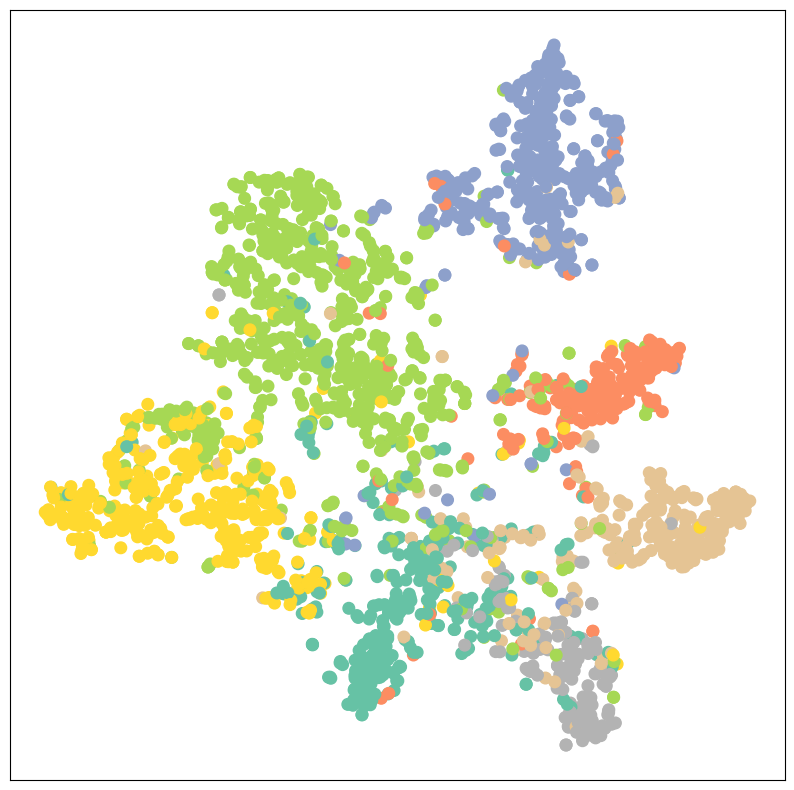

In [30]:
model.eval() # 转换为测试模式
out = model(data.x, data.edge_index)
visualize(out, color=data.y)
